# CNN implementation sanity checks

In [1]:
import sys, os
sys.path.append(os.path.join(os.path.dirname('.'), '../lib/'))

import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


from cs231n.classifiers.cnn import *
from cs231n.gradient_check import eval_numerical_gradient_array, eval_numerical_gradient
from cs231n.layers import *
from cs231n.fast_layers import *
from cs231n.solver import Solver



%matplotlib inline

plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [2]:
from cs231n.layer_utils import conv_relu_pool_forward, conv_relu_pool_backward

x = np.random.randn(2, 3, 16, 16)
w = np.random.randn(3, 3, 3, 3)
b = np.random.randn(3,)
dout = np.random.randn(2, 3, 8, 8)
conv_param = {'stride': 1, 'pad': 1}
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

out, cache = conv_relu_pool_forward(x, w, b, conv_param, pool_param)
dx, dw, db = conv_relu_pool_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: conv_relu_pool_forward(x, w, b, conv_param, pool_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_relu_pool_forward(x, w, b, conv_param, pool_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_relu_pool_forward(x, w, b, conv_param, pool_param)[0], b, dout)

print 'Testing conv_relu_pool'
print 'dx error: ', rel_error(dx_num, dx)
print 'dw error: ', rel_error(dw_num, dw)
print 'db error: ', rel_error(db_num, db)

Testing conv_relu_pool
dx error:  3.16691820263e-08
dw error:  1.01824948723e-09
db error:  1.48697810021e-11


## Sanity check loss
After you build a new network, one of the first things you should do is sanity check the loss. When we add regularization this should go up.

In [3]:
model = ThreeLayerConvNet(input_dim=(1, 96, 96), num_filters=32, filter_size=7,
               hidden_dim=100, num_outputs=15, weight_scale=1e-3, reg=0.0,
               dtype=np.float32)

N = 50
X = np.random.randn(N, 1, 96, 96)
y = np.random.randn(N, 15)

loss, grads = model.loss(X, y)
print 'Initial loss (no regularization): ', loss

model.reg = 0.5
loss, grads = model.loss(X, y)
print 'Initial loss (with regularization): ', loss

Initial loss (no regularization):  14.5795477901
Initial loss (with regularization):  759.571308044


## Gradient check
After the loss looks reasonable, use numeric gradient checking to make sure that your backward pass is correct. When you use numeric gradient checking you should use a small amount of artifical data and a small number of neurons at each layer.

In [4]:
# Gradient check for l2_loss implementation
num_outputs = 30

x = np.random.randn(num_outputs)
y = np.random.randn(num_outputs)

loss, dx = l2_loss(x, y)

f = lambda _: l2_loss(x, y)[0]
param_grad_num = eval_numerical_gradient(f, x, verbose=False, h=1e-6)
e = rel_error(param_grad_num, dx)
print '%s max relative error: %e' % ('x', e)

assert e < 1e-6, 'L2 Loss function gradient check fail'

x max relative error: 1.542081e-08


In [5]:
# Gradient check for model.loss

num_inputs = 2
input_dim = (1, 16, 16)
reg = 0.0
num_outputs = 30
X = np.random.randn(num_inputs, *input_dim)
y = np.random.randn(num_inputs, num_outputs)

model = ThreeLayerConvNet(num_filters=3, filter_size=3,
                          input_dim=input_dim, hidden_dim=7,
                          num_outputs=num_outputs, loss_fn=l2_loss,
                          dtype=np.float64, weight_scale=1e-2,
                        )
loss, grads = model.loss(X, y)
for param_name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    param_grad_num = eval_numerical_gradient(f, model.params[param_name], verbose=False, h=1e-6)
    e = rel_error(param_grad_num, grads[param_name])
    print '%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name]))

W1 max relative error: 4.064839e-08
W2 max relative error: 7.167428e-06
W3 max relative error: 2.241873e-05
b1 max relative error: 2.648591e-09
b2 max relative error: 3.428393e-10
b3 max relative error: 9.025132e-09


## Overfit small data
A nice trick is to train your model with just a few training samples. You should be able to overfit small datasets, which will result in very high training accuracy and comparatively low validation accuracy.

In [6]:
# Load previously cleaned data

import os

np_loaded_data_file = '../data/train_data_cleaned.npz'
if not os.path.isfile(np_loaded_data_file):
    print "%s does not exist. See facial_recog_kaggle.ipynb" % np_loaded_data_file
else:
    print "loading %s" % np_loaded_data_file
    npzfile = np.load(np_loaded_data_file)
    print "loaded: ", npzfile.files
    X_train_clean, y_train_clean = npzfile['X_train_clean_cv'], npzfile['y_train_clean_cv']
    X_val_clean, y_val_clean = npzfile['X_val_clean_cv'], npzfile['y_val_clean_cv']
    feature_labels = npzfile['feature_labels']
    

print "X_train_clean.shape = ", X_train_clean.shape
print "X_val_clean.shape = ", X_val_clean.shape
        



loading ../data/train_data_cleaned.npz
loaded:  ['X_val_clean_cv', 'y_val_clean_cv', 'y_train_clean_cv', 'feature_labels', 'X_train_clean_cv']
X_train_clean.shape =  (1640, 1, 96, 96)
X_val_clean.shape =  (500, 1, 96, 96)


In [17]:
%%time
num_train = 200
num_val = 50

rand_idx = np.random.choice(num_train, num_train, replace=False)
X_train_small = X_train_clean[rand_idx]
y_train_small = y_train_clean[rand_idx]

rand_idx = np.random.choice(num_val, num_val, replace=False)
X_val_small = X_train_clean[rand_idx]
y_val_small = y_train_clean[rand_idx]

small_data = {
  'X_train': X_train_small,
  'y_train': y_train_small,
  'X_val': X_val_small,
  'y_val': y_val_small,
}


model = ThreeLayerConvNet(num_filters=32, filter_size=3,
                          loss_fn=l2_loss, 
                          dtype=np.float64, weight_scale=1e-3)

solver = Solver(model, small_data,
                num_epochs=20, batch_size=25,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-5,
                },
                verbose=True)
solver.train()

(Iteration 1 / 160) loss: 78053.543349
(Epoch 0 / 20) train acc: 2491.052960; val_acc: 2507.266097
(Epoch 1 / 20) train acc: 817.551414; val_acc: 805.330517
(Iteration 11 / 160) loss: 21327.915896
(Epoch 2 / 20) train acc: 351.358807; val_acc: 318.026581
(Iteration 21 / 160) loss: 9587.604555
(Epoch 3 / 20) train acc: 282.983663; val_acc: 279.170323
(Iteration 31 / 160) loss: 7563.623157
(Epoch 4 / 20) train acc: 236.370956; val_acc: 192.234509
(Epoch 5 / 20) train acc: 186.038733; val_acc: 172.375698
(Iteration 41 / 160) loss: 5769.859554
(Epoch 6 / 20) train acc: 168.039600; val_acc: 148.838260
(Iteration 51 / 160) loss: 4653.094912
(Epoch 7 / 20) train acc: 153.117183; val_acc: 138.056468
(Iteration 61 / 160) loss: 4010.098037
(Epoch 8 / 20) train acc: 146.239357; val_acc: 127.439697
(Iteration 71 / 160) loss: 4917.507834
(Epoch 9 / 20) train acc: 137.738912; val_acc: 122.315320
(Epoch 10 / 20) train acc: 131.240554; val_acc: 122.509832
(Iteration 81 / 160) loss: 4132.011634
(Epoch 

(21, 15)


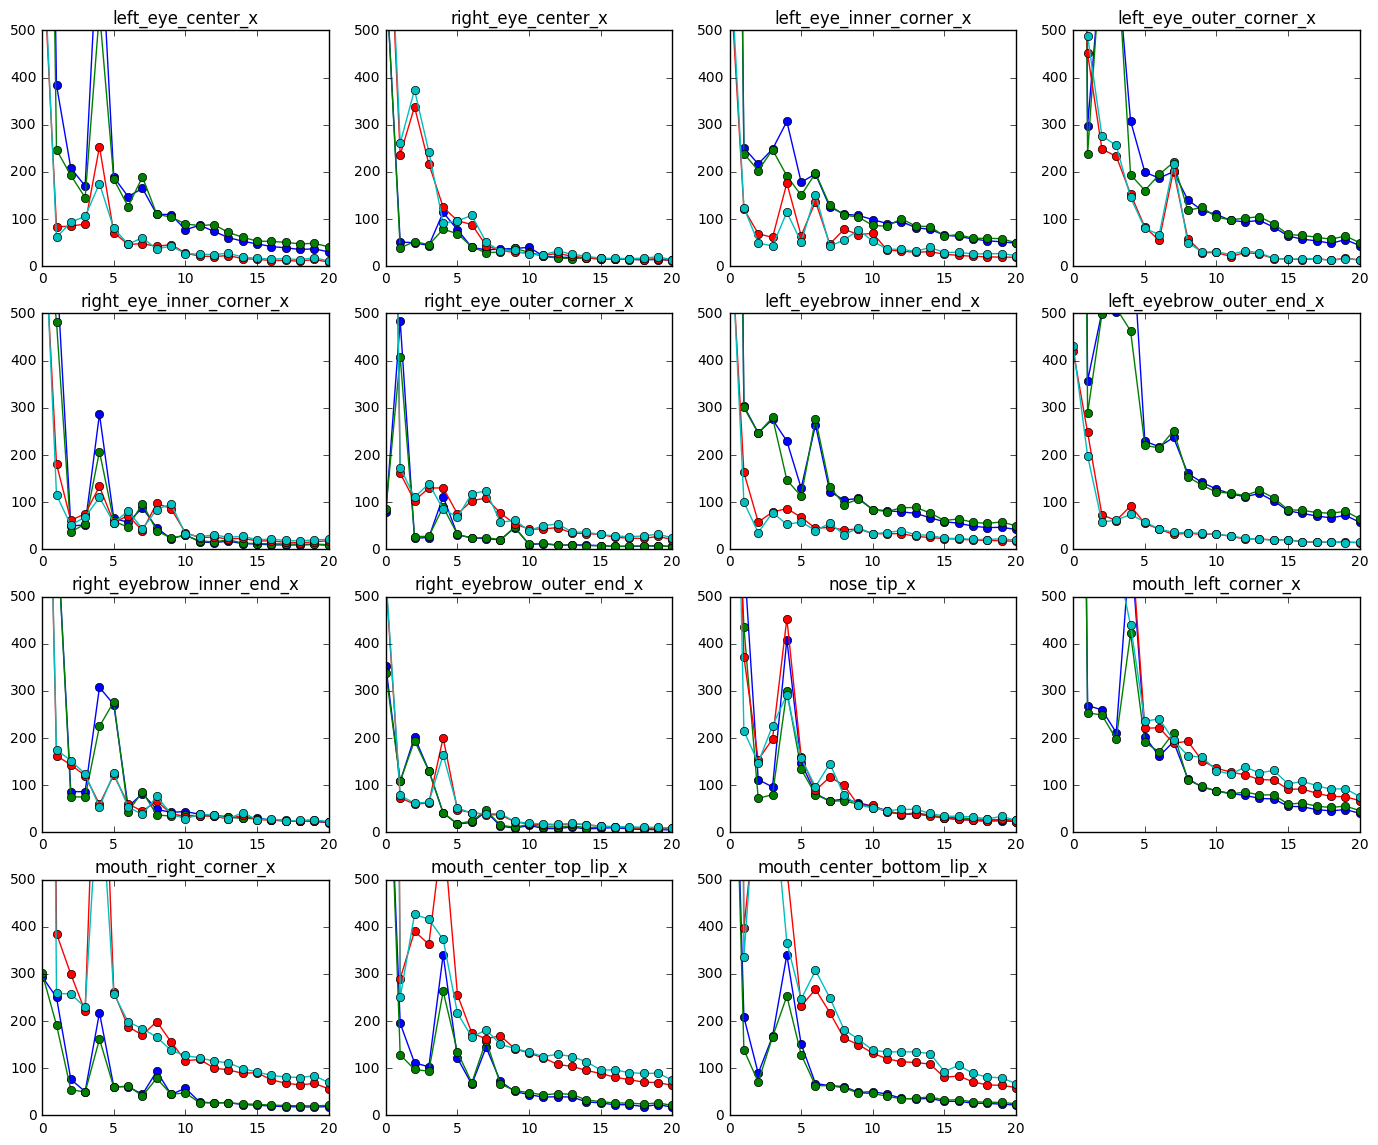

In [8]:
# Visualize the training and validation acc for different features.
train_acc_hist = np.vstack(solver.train_acc_history)
val_acc_hist = np.vstack(solver.val_acc_history)

train_acc_hist_feat_x = train_acc_hist[: , 0::2]
train_acc_hist_feat_y = train_acc_hist[: , 1::2]

val_acc_hist_feat_x = val_acc_hist[: , 0::2]
val_acc_hist_feat_y = val_acc_hist[: , 1::2]

print train_acc_hist_feat_x.shape

num_epochs, num_features = train_acc_hist_feat_x.shape
num_grid_x, num_grid_y = int(np.ceil(np.sqrt(num_features))), int(np.ceil(np.sqrt(num_features)))

feature_labels_x = feature_labels[0::2]

for nx in range(num_grid_x):
    for ny in range(num_grid_y):
        feat_idx = nx * num_grid_y + ny
        if feat_idx >= num_features:
            break
        plt.subplot(num_grid_x, num_grid_y, feat_idx + 1)
        plt.plot(train_acc_hist_feat_x[:, feat_idx], '-o', label='train_x')
        plt.plot(val_acc_hist_feat_x[:, feat_idx], '-o', label='val_x')
        plt.plot(train_acc_hist_feat_y[:, feat_idx], '-o', label='train_y')
        plt.plot(val_acc_hist_feat_y[:, feat_idx], '-o', label='val_y')
        plt.title(feature_labels_x[feat_idx])
        plt.ylim((0,500))
        

plt.gcf().set_size_inches(17, 14)
plt.show()
        

## Learning curves
Learning curves plot Jtrain, Jcv as a function of the num_training_examples. They help identify high-bias/ high-variance problems. In current scenario, a small dataset should make the model overfit the data. 

In [9]:
# num_train_vec = [10, 20, 50, 100, 200]
# num_val = 200

# train_acc_vec = []
# val_acc_vec = []

# for num_train in num_train_vec:
#     rand_idx = np.random.choice(num_train + num_val, num_train + num_val, replace=False)
#     X_train_small = X_train_clean[rand_idx[:num_train]]
#     y_train_small = y_train_clean[rand_idx[:num_train]]

#     X_val_small = X_train_clean[rand_idx[num_train:num_train + num_val]]
#     y_val_small = y_train_clean[rand_idx[num_train:num_train + num_val]]

#     small_data = {
#       'X_train': X_train_small,
#       'y_train': y_train_small,
#       'X_val': X_val_small,
#       'y_val': y_val_small,
#     }


#     model = ThreeLayerConvNet(num_filters=16, filter_size=3,
#                               loss_fn=l2_loss, 
#                               dtype=np.float64, weight_scale=1e-3)

#     solver = Solver(model, small_data,
#                     num_epochs=20, batch_size=25,
#                     update_rule='adam',
#                     optim_config={
#                       'learning_rate': 1e-4,
#                     },
#                     verbose=False)
#     solver.train()
    
#     train_acc_vec.append(np.mean(solver.train_acc_history[-1]))
#     val_acc_vec.append(np.mean(solver.val_acc_history[-1]))
    
#     print 'num_train = %d, train_acc = %e, val_acc = %e' % (num_train, train_acc_vec[-1], val_acc_vec[-1])


num_train = 10, train_acc = 2.744849e+02, val_acc = 4.007368e+02
num_train = 20, train_acc = 1.805220e+02, val_acc = 2.424732e+02
num_train = 50, train_acc = 6.714233e+01, val_acc = 1.293206e+02
num_train = 100, train_acc = 5.986786e+01, val_acc = 1.258120e+02
num_train = 200, train_acc = 2.349232e+01, val_acc = 5.426340e+01


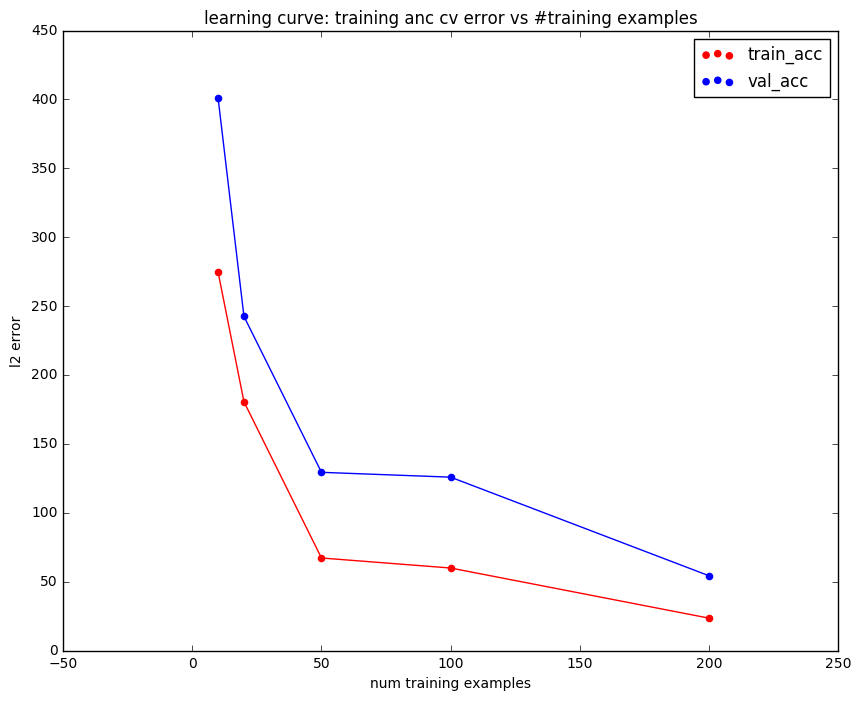

In [10]:
# Visualize

plt.scatter(num_train_vec, train_acc_vec, label='train_acc', color='red')
plt.plot(num_train_vec, train_acc_vec, color='red')
plt.scatter(num_train_vec, val_acc_vec, label='val_acc', color='blue')
plt.plot(num_train_vec, val_acc_vec, color='blue')
plt.legend()
plt.xlabel('num training examples')
plt.ylabel('l2 error')
plt.title('learning curve: training anc cv error vs #training examples')
plt.show()